### Time Series Forecasting with LSTM

The goal of this notebook is to implement a basic example of LSTM with application in time series prediction (forecasting). 
For this purpose, the notebook will play with two different aspects in order to understand its performance:
- **Synthetic data**: It will generated synthetic seasonal data and played with different forecast time horizonts, noise addition and period patterns.
- **LSTM time steps**: The time series sequence will be partioned in batches of different sequence lenght (or time steps)

References

[1] https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
tf.get_logger().setLevel('INFO')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

mpl.rcParams['figure.figsize'] = 20, 10

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

import sys
sys.path.append('../utils/')
import time_series_utils

Using TensorFlow backend.


#### Auxiliar functions

A Vanilla LSTM Model with a single hidden layer of LSTM units and a output layer used to make prediction. The model will expect the input component of training data to have the dimensions or shape: [samples, timesteps, features]

In [2]:
def lstm_model(X, ts_Y_train, n_steps, n_features):
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, ts_Y_train, epochs=200, verbose=0)
    return model

In [3]:
def plot_ts_forecast(ts_Y_train, ts_Y_test, yhat):
    forecast_h = len(yhat)
    train_window = len(ts_Y_train)
    x_length = forecast_h+train_window
    aa=[x for x in range(x_length)]
    plt.figure(figsize=(20,8))
    plt.plot(aa[:train_window], ts_Y_train, marker='.', label="train")
    plt.plot(aa[train_window:], ts_Y_test, marker='.', label="test")
    plt.plot(aa[train_window:], yhat.reshape(-1), 'r', label="prediction")
    plt.tight_layout()
    plt.subplots_adjust(left=0.07)
    plt.xlabel('time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

## Experiments with synthetic data

It will generated a synthetic time series to show how affect the performance different factors:
* 1 - *Noise addition*. 2 different factor levels: 0.01 and 0.5
* 2 - *Period*. A fixed resolution frequency 'H' or hourly with 2 different periods: 24 period (24h-day) and (72h-3day)
* 3 - *Forecast horizon*. TODO (1 hour as default)
* 4 - *Training sequence lenght*. 2 different training time series sequence lengths: 1 day, 100 days 

#### Common  parameters

In [4]:
# ------Time series
t0 = '2016-01-01 00:00:00'
freq = 'H'
num_ts = 1

# default - changed in each experiemnt to test different behaviors
noise_level = 0.05
period = 14

# train, test
total_days = 20
tseries_length = total_days * 24 # hourly freq
train_days = 15 * 24

# ------LSTM
n_features = 1 # We are working with univariate series so the number of features is 1
n_steps=2 # we will work with a batch of 2 time steps

### Experiment 1 - Noise Addition

In [5]:
noise_level = 0.5 # <---- play with this parameter

In [6]:
time_series_df = time_series_utils.generate_synth_tseries(t0, tseries_length, num_ts, period, freq, noise_level)

In [7]:
time_series_df.head()

,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00,2016-01-01 03:00:00,2016-01-01 04:00:00,2016-01-01 05:00:00,2016-01-01 06:00:00,2016-01-01 07:00:00,2016-01-01 08:00:00,2016-01-01 09:00:00,...,2016-01-20 14:00:00,2016-01-20 15:00:00,2016-01-20 16:00:00,2016-01-20 17:00:00,2016-01-20 18:00:00,2016-01-20 19:00:00,2016-01-20 20:00:00,2016-01-20 21:00:00,2016-01-20 22:00:00,2016-01-20 23:00:00
0,6.586344,8.425624,15.665364,9.096094,8.194079,10.535328,5.49989,3.219473,-2.752563,12.696968,...,5.063891,9.142537,9.686792,6.874204,9.534701,9.038957,10.46944,14.751856,5.709304,2.693938


##### Split in train and test

Split the series in training and testing using the specified train_days

In [8]:
train_ts = time_series_df.iloc[:, 0:train_days].rename({0:'train series'})
test_ts = time_series_df.iloc[:,train_days-1:].rename({0:'test series'})

##### Generate batches or samples of n_steps time steps

In [9]:
ts_X_test, ts_Y_test = time_series_utils.split_sequence(test_ts.values[0], n_steps)
ts_X_train, ts_Y_train = time_series_utils.split_sequence(train_ts.values[0], n_steps)

In [10]:
# reshape as input for the lstm
X = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], n_features)) #  sequence lenght, n_steps and features per time step

##### Create LSTM model and generate forecast 

In [11]:
model = lstm_model(X, ts_Y_train, n_steps, n_features)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [12]:
# demonstrate prediction
x_input = ts_X_test
x_input = x_input.reshape((ts_X_test.shape[0], ts_X_test.shape[1], n_features))
yhat = model.predict(x_input, verbose=0)

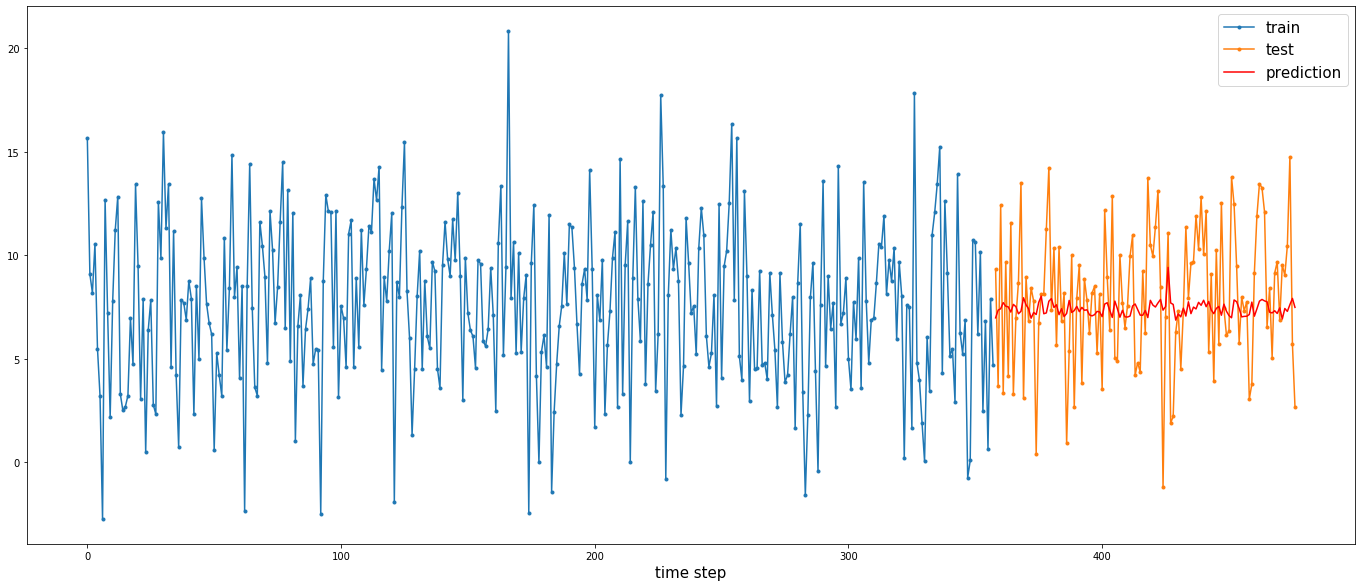

In [13]:
plot_ts_forecast(ts_Y_train, ts_Y_test, yhat)

In [14]:
noise_level = 0 # reset noise

### Experiment 2 - Period

In [15]:
period = 72 # <---- play with this parameter

In [16]:
time_series_df = time_series_utils.generate_synth_tseries(t0, tseries_length, num_ts, period, freq, noise_level)

In [17]:
train_ts, test_ts = time_series_df.iloc[:, 0:train_days], time_series_df.iloc[:,train_days:] 

In [18]:
n_steps=2
ts_X_test, ts_Y_test = time_series_utils.split_sequence(test_ts.values[0], n_steps)
ts_X_train, ts_Y_train = time_series_utils.split_sequence(train_ts.values[0], n_steps)
n_features = 1
# reshape as input for the lstm
X = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], n_features)) # sequence lenght, n_steps and features per time step

model = lstm_model(X, ts_Y_train, n_steps, n_features)
# demonstrate prediction
x_input = ts_X_test
x_input = x_input.reshape((ts_X_test.shape[0], ts_X_test.shape[1], n_features))
yhat = model.predict(x_input, verbose=0)

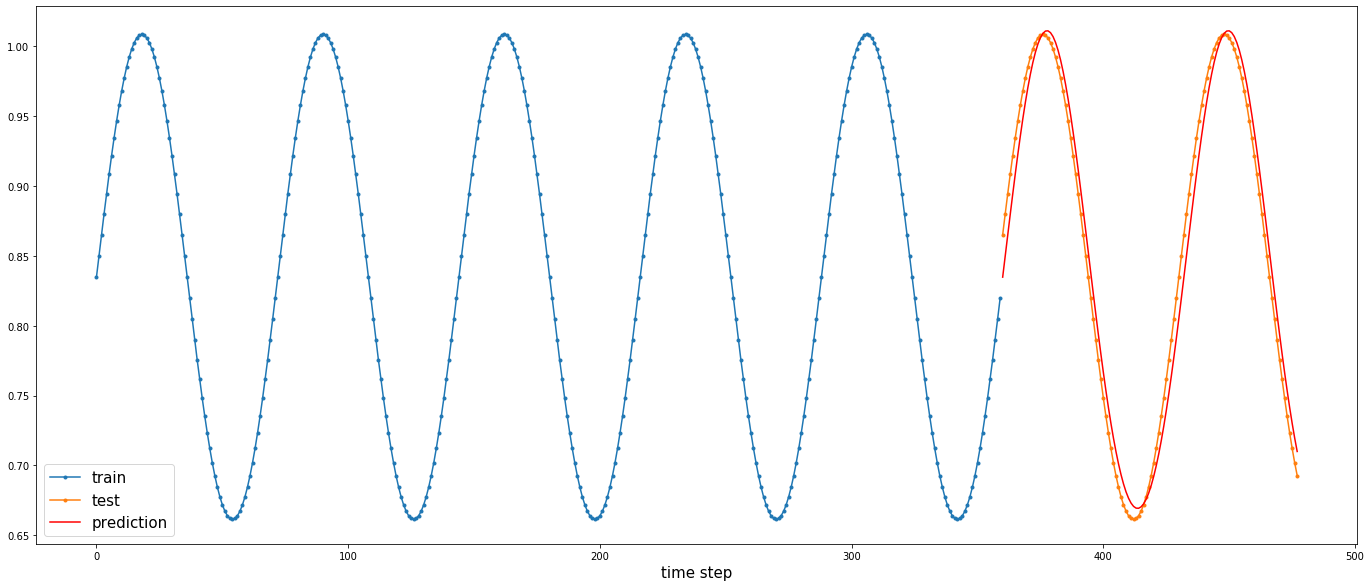

In [19]:
plot_ts_forecast(train_ts.T.values, ts_Y_test, yhat)

In [20]:
period = 14 # reset default period

### Experiment 4 - Training sequence length

In [21]:
train_days = 15 * 24 # <---- play with this parameter

In [22]:
time_series_df = time_series_utils.generate_synth_tseries(t0, tseries_length, num_ts, period, freq, noise_level)

In [23]:
train_ts, test_ts = time_series_df.iloc[:, 0:train_days], time_series_df.iloc[:,train_days:] 
ts_X_test, ts_Y_test = time_series_utils.split_sequence(test_ts.values[0], n_steps)
ts_X_train, ts_Y_train = time_series_utils.split_sequence(train_ts.values[0], n_steps)
n_features = 1
# reshape as input for the lstm
X = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], n_features)) #  sequence lenght, n_steps and features per time step

model = lstm_model(X, ts_Y_train, n_steps, n_features)
# demonstrate prediction
x_input = ts_X_test
x_input = x_input.reshape((ts_X_test.shape[0], ts_X_test.shape[1], n_features))
yhat = model.predict(x_input, verbose=0)

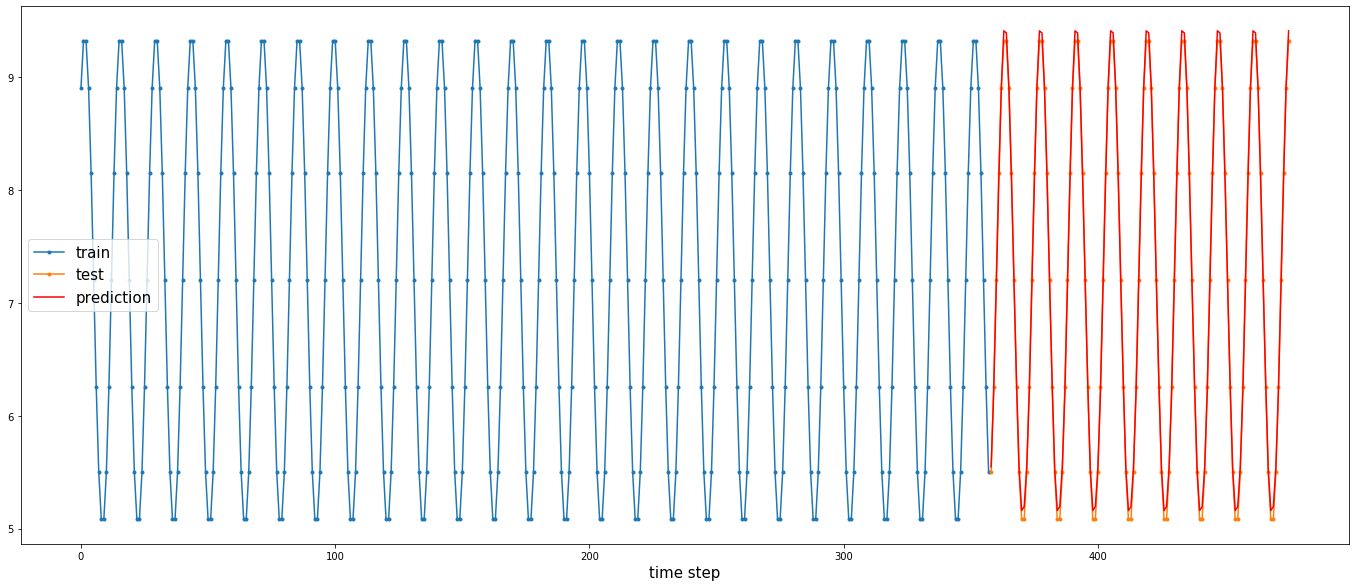

In [24]:
plot_ts_forecast(ts_Y_train, ts_Y_test, yhat)